Michał Zych, michal.zych96@gmail.com

Michał Warzecha, warzmich@gmail.com

**Ze wzglęzdu na to, że w Lecture1a wszystkie dane do trenowania były ze zbioru bez preproccesingu, w tym nootebooku wytrenowano klasyfikatory zarówno na zbiorze bez jak i z preproccesingiem w postaci wyprostowania tekstu (funkcja deskew)**

In [0]:
%tensorflow_version 1.x
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn import svm

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

In [0]:
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

In [0]:
## [deskew]
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]

70000
70000
60000
10000


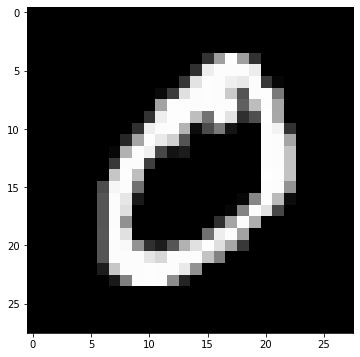

0


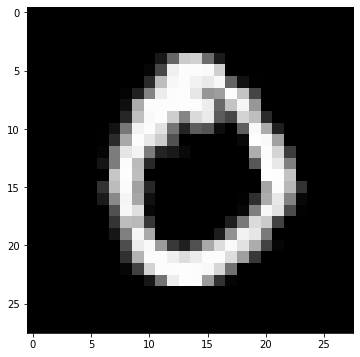

0


In [0]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

im_list = [train_images[i] for i in range(0,train_images.shape[0])] + [test_images[i] for i in range(0,test_images.shape[0])]
print(len(im_list))

list_deskew = [deskew(im) for im in im_list]
train_deskew = list_deskew[0:train_images.shape[0]]
test_deskew = list_deskew[train_images.shape[0]:]

list_deskew = np.asarray(list_deskew)
train_deskew = np.asarray(train_deskew)
test_deskew = np.asarray(test_deskew)


print(len(list_deskew))
print(len(train_deskew))
print(len(test_deskew))

showOpencvImage(train_images[1])
print(train_labels[1])

showOpencvImage(train_deskew[1])
print(train_labels[1])



In [0]:
hogdata = [openCVHOG(im) for im in im_list]
print(len(hogdata))
print(hogdata[0].shape)
imData = np.float32(hogdata).reshape(-1,81)
print(imData.shape)


hogdata_deskew = [openCVHOG(im) for im in list_deskew]
print(len(hogdata_deskew))
print(hogdata_deskew[0].shape)
imData_deskew = np.float32(hogdata_deskew).reshape(-1,81)
print(imData_deskew.shape)

70000
(81,)
(70000, 81)
70000
(81,)
(70000, 81)


**SVM**

In [0]:
#Funkcja do wyboru najlepszych parametrow modelu SVM w przedziale C = 10:20, gamma = 0.1:0.9
def best_SVM_model_based_on_cross_validation(train_data, train_labels):
  Cs = np.arange(10, 20, 0.5).tolist()
  gammas = np.arange(0.1, 0.9, 0.1).tolist()
  len_validation_data = len(train_data)/5
  max_correct =0
  best_C = 0
  best_gamma = 0
  len_training_data_cs = int(4* len_validation_data)
  
  for C in Cs:
    for gamma in gammas:
      model = svm.SVC(C=C, gamma=gamma)
      model = model.fit(train_data[0:len_training_data_cs,:],train_labels[0:len_training_data_cs])

      pred_labels = model.predict(train_data[len_training_data_cs:,:])

      mask = pred_labels==train_labels[len_training_data_cs:]
      correct = np.count_nonzero(mask)
      if correct > max_correct:
        max_correct = correct
        best_C = C
        best_gamma = gamma

  model = svm.SVC(C=best_C, gamma=best_gamma)
  model = model.fit(train_data, train_labels)
  return model




#WITHOUT DESKEW
model = best_SVM_model_based_on_cross_validation(imData[0:600,:],train_labels[0:600])
pred_labels = model.predict(imData[600:1000,:])

#WITH DESKEW
model = best_SVM_model_based_on_cross_validation(imData_deskew[0:600,:],train_labels[0:600])
pred_labels_deskew = model.predict(imData_deskew[600:1000,:])

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

mask = pred_labels==train_labels[600:1000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(train_labels[600:1000], pred_labels)
print("WITHOUT DESKEW")
print(cm)
print(classification_report(train_labels[600:1000], pred_labels))
print()


mask = pred_labels_deskew==train_labels[600:1000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels_deskew.size)

cm = confusion_matrix(train_labels[600:1000], pred_labels_deskew)
print("WITH DESKEW")
print(cm)
print(classification_report(train_labels[600:1000], pred_labels_deskew))

91.25
WITHOUT DESKEW
[[37  0  1  0  0  0  1  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  2  1  1]
 [ 0  0  1 32  0  0  0  0  0  1]
 [ 0  0  0  0 40  2  4  0  0  0]
 [ 0  0  2  1  0 36  0  0  1  1]
 [ 1  1  0  0  1  0 36  0  1  0]
 [ 0  0  3  1  1  0  0 50  0  0]
 [ 0  0  0  0  0  1  0  0 36  1]
 [ 4  0  0  0  0  0  0  1  0 30]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        39
           1       0.97      1.00      0.99        37
           2       0.82      0.89      0.85        35
           3       0.94      0.94      0.94        34
           4       0.95      0.87      0.91        46
           5       0.92      0.88      0.90        41
           6       0.88      0.90      0.89        40
           7       0.94      0.91      0.93        55
           8       0.92      0.95      0.94        38
           9       0.88      0.86      0.87        35

    accuracy                           0.91       40

**Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier

#Funkcja do wyboru najlepszych parametrow modelu RandomForest w przedziale max_depth = 10:20, n_estimators = 50:150, max_features = 50:70
def best_random_forest_model_based_on_cross_validation(train_data, train_labels):
  max_depth = list(range(10,21))
  n_estimators = list(range(50,151,10))
  max_features = list(range(50,70,10))
  len_validation_data = len(train_data)/5
  max_correct =0
  best_max_depth = 0
  best_n_estimators = 0
  best_max_features = 0
  len_training_data_cs = int(4* len_validation_data)
  
  for depth in max_depth:
    for estimator in n_estimators:
      for features in max_features:
        rfc = RandomForestClassifier(max_depth=depth, n_estimators=estimator, max_features=features)
        rfc = rfc.fit(train_data[0:len_training_data_cs,:],train_labels[0:len_training_data_cs])

        pred_labels = rfc.predict(train_data[len_training_data_cs:,:])

        mask = pred_labels==train_labels[len_training_data_cs:]
        correct = np.count_nonzero(mask)
        if correct > max_correct:
          max_correct = correct
          best_max_depth = depth
          best_n_estimators = estimator
          best_max_features = features

  rfc = RandomForestClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators, max_features=best_max_features)
  rfc = rfc.fit(train_data, train_labels)
  return rfc

In [0]:
#WITHOUT DESKEW
rfc = best_random_forest_model_based_on_cross_validation(imData[0:600,:],train_labels[0:600])

pred_labels = rfc.predict(imData[600:1000,:])

mask = pred_labels==train_labels[600:1000]
correct = np.count_nonzero(mask)
print("WITHOUT DESKEW")
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(train_labels[600:1000], pred_labels)
print(cm)
print(classification_report(train_labels[600:1000], pred_labels))
print()

#WITH DESKEW
rfc =  best_random_forest_model_based_on_cross_validation(imData_deskew[0:600,:],train_labels[0:600])

pred_labels_deskew = rfc.predict(imData_deskew[600:1000,:])

mask = pred_labels_deskew==train_labels[600:1000]
correct = np.count_nonzero(mask)
print("WITH DESKEW")
print(correct*100.0/pred_labels_deskew.size)

cm = confusion_matrix(train_labels[600:1000], pred_labels_deskew)
print(cm)
print(classification_report(train_labels[600:1000], pred_labels_deskew))

WITHOUT DESKEW
84.0
[[28  0  1  0  0  0  8  2  0  0]
 [ 0 36  0  0  0  1  0  0  0  0]
 [ 0  0 31  0  1  1  0  1  0  1]
 [ 0  0  1 30  0  2  0  1  0  0]
 [ 0  0  0  0 42  1  2  0  0  1]
 [ 0  0  1  1  1 33  1  0  2  2]
 [ 1  2  0  0  2  1 34  0  0  0]
 [ 0  0  4  2  1  0  0 48  0  0]
 [ 3  4  0  0  2  1  0  0 27  1]
 [ 2  1  2  0  1  1  0  1  0 27]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        39
           1       0.84      0.97      0.90        37
           2       0.78      0.89      0.83        35
           3       0.91      0.88      0.90        34
           4       0.84      0.91      0.87        46
           5       0.80      0.80      0.80        41
           6       0.76      0.85      0.80        40
           7       0.91      0.87      0.89        55
           8       0.93      0.71      0.81        38
           9       0.84      0.77      0.81        35

    accuracy                           0.84       400

**Neural Network**

In [0]:
from keras import models
from keras import layers

def build_network(number_of_first_layer_units):
  network = models.Sequential()
  network.add(layers.Dense(number_of_first_layer_units, activation='relu', input_shape=(28 * 28,)))
  network.add(layers.Dense(10, activation='softmax'))
  return network


def prepare_best_network(train_data, train_labels):
  nr = 0
  numbers_of_first_layer_units = [np.power(2,x) for x in range(1,10)]
  len_validation_data = len(train_data)/5
  best_numbers = 0
  len_training_data_cs = int(4* len_validation_data)
  max_test_acc = 0
  
  for number in numbers_of_first_layer_units:
    nr+=1
    print("Iteration #" + str(nr))
    network = build_network(number)
    network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    network.fit(train_data[0:len_training_data_cs,:], train_labels[0:len_training_data_cs], epochs=5, batch_size=128, verbose=0)

    test_loss, test_acc = network.evaluate(test_images, encoded_test_labels, verbose=0)
    print(test_acc)
    if test_acc > max_test_acc:
      max_test_acc = test_acc
      best_numbers = number

  print(best_numbers)
  network = build_network(best_numbers)
  network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  network.fit(train_data, train_labels, epochs=5, batch_size=128)
  return network

In [0]:
#WITHOUT DESKEW
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

#WITH DESKEW
train_deskew = train_deskew.reshape((60000, 28 * 28))
train_deskew = train_deskew.astype('float32') / 255

test_deskew = test_deskew.reshape((10000, 28 * 28))
test_deskew = test_deskew.astype('float32') / 255

In [0]:
from keras.utils import to_categorical

encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

encoded_test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
#WITHOUT DESKEW
print("NETWORK_WITHOUT_DESKEW")
network = prepare_best_network(train_images, encoded_train_labels)
print()
print("NETWORK_DESKEW")
print()
network_deskew = prepare_best_network(train_deskew, encoded_train_labels)

NETWORK_WITHOUT_DESKEW
Iteration #1





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








0.5651
Iteration #2
0.8151
Iteration #3
0.9144
Iteration #4
0.9379
Iteration #5
0.9517
Iteration #6
0.9614
Iteration #7
0.9709
Iteration #8
0.9759
Iteration #9
0.9801
512
Epoch 1/5
60000/60000 [==============================] - 4s 73us/step - loss: 0.2620 - acc: 0.9235
Epoch 2/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.1060 - acc: 0.9683
Epoch 3/5
60000/60000 [==============================] - 4s 67us/step - loss: 0.0699 - acc: 0.9789
Epoch 4/5
60000/60000 [==============================] - 4s 67us/step - loss: 0.0517 - acc: 0.9841
Epoch 5/5
60000/60000 [==============================] - 4s 67us/step - loss: 0.0391 - acc: 0.9880

NETWORK_DESKEW

Iteration #1
0.4845
Iteration #2
0.6354
Iteration #3
0.775
Iteration #4
0.7693
Iteration #5
0.7952
Iteration #6
0.7971
Iteration #7
0.8243
Iteration #8
0.8299
Iteration #9
0.

In [0]:
#WITHOUT DESKEW
print("WITHOUT DESKEW")
test_loss, test_acc = network.evaluate(test_images, encoded_test_labels)
print('test_acc:', test_acc)
print()

#WITH DESKEW
test_loss, test_acc = network_deskew.evaluate(test_deskew, encoded_test_labels)
print("WITH DESKEW")
print('test_acc:', test_acc)

WITHOUT DESKEW
10000/10000 [==============================] - 1s 72us/step
test_acc: 0.9817

10000/10000 [==============================] - 1s 59us/step
WITH DESKEW
test_acc: 0.9831


In [0]:
#WITHOUT DESKEW
print("WITHOUT DESKEW")
pred_probabilities = network.predict(test_images)
print(pred_probabilities[0:1])
print()

#WITH DESKEW
pred_probabilities_deskew = network_deskew.predict(test_deskew)
print("WITH DESKEW")
print(pred_probabilities_deskew[0:1])

WITHOUT DESKEW
[[8.0953741e-09 2.2255571e-11 3.7311456e-06 1.0927809e-05 6.9331186e-12
  4.4205546e-08 9.0450142e-15 9.9998498e-01 2.7401869e-08 3.3917644e-07]]

WITH DESKEW
[[3.7672674e-08 6.2190980e-10 9.0421571e-07 4.3463431e-05 1.3084688e-10
  1.6492687e-09 1.3019673e-12 9.9995124e-01 1.1319336e-07 4.1494636e-06]]


7


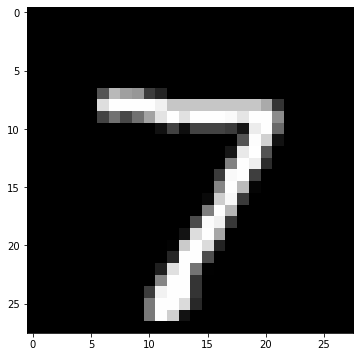

In [0]:
#WITHOUT DESKEW
pred_labels = np.argmax(pred_probabilities,-1)
print(pred_labels[0])
showOpencvImage(test_images[0].reshape(28,-1))

#WITH DESKEW
pred_labels_deskew = np.argmax(pred_probabilities_deskew,-1)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

#WITHOUT DESKEW
cm = confusion_matrix(test_labels, pred_labels)
print("WITHOUT DESKEW")
print(cm)
print(classification_report(test_labels, pred_labels))
print()

#WITH DESKEW
cm = confusion_matrix(test_labels, pred_labels_deskew)
print("WITH DESKEW")
print(cm)
print(classification_report(test_labels, pred_labels_deskew))

WITHOUT DESKEW
[[ 969    0    1    3    1    1    1    1    2    1]
 [   0 1125    4    1    0    0    2    0    3    0]
 [   1    0 1012    3    4    0    2    6    4    0]
 [   0    0    2  996    0    1    0    3    2    6]
 [   0    0    4    0  972    0    1    1    1    3]
 [   2    0    0   11    2  867    3    0    4    3]
 [   3    3    1    1    8    3  936    0    3    0]
 [   1    5   11    3    0    0    0  999    1    8]
 [   0    0    4    6    3    1    0    3  953    4]
 [   0    2    0    5   11    0    0    3    0  988]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.

WNIOSKI:

Preproccesing w postaci wyprostowania litery (deskew) pozwala na uzyskanie lepszych wyników dla poszczególnych klasyfikatorów. Największą różnicę widać dla klasyfikatora Random Forest. Dla sieci neuronowej użycie preproccesingu zmieniło rezultat działania w tym przypadku tylko o około 0.1% (na plus), ale warto zauważyć, że sieć neuronowa uzyskała wartość parametru accuracy (precyzja) na poziomie 98% 